## Bayesian Linear Regression

In [1]:
%pylab inline
import scipy.stats as stats

Populating the interactive namespace from numpy and matplotlib


#### Model

We use a linear regression model, and assume that observed values $y$ differ from function values by additive Gaussian noise:

\begin{align}
f(\mathbf{x}) &=\mathbf{x}^\top\mathbf{w}\\
y &= f(\mathbf{x})+\epsilon\\
\epsilon &\sim \mathcal{N}(0,\sigma^2)
\end{align}

In the input $\textbf{x}$ we add an **extra dimension set to 1**  so that the **bias** is included in $\mathbf{w}$:
\begin{align}
\mathbf{x} &= [1, x]\\
\mathbf{w} &= [b, w]\\
\mathbf{x}^\top\mathbf{w} & \equiv wx+b
\end{align}


#### Generating the observations (targets)

We assume that $\sigma^2$ is known. The true parameter $\mathbf{w}^*$ is unknown.

In [2]:
def targets(n, w_true, var):
    x = np.random.uniform(-1, 1, n)
    x = np.stack((np.ones(n), x), 1)
    eps = np.random.normal(0, var, n)
    y = np.dot(x, w_true) + eps
    return x, y

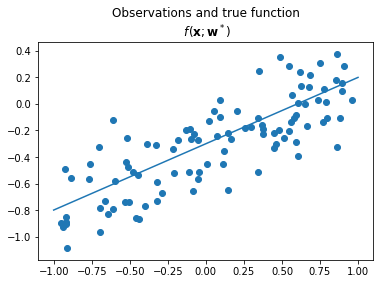

In [3]:
SIG_SQ = 0.2
W_TRUE = np.array([-0.3, 0.5])
N = 100

X_TRUE, Y_TRUE = targets(N, W_TRUE, SIG_SQ)

plt.scatter(X_TRUE[:, 1], Y_TRUE)
plt.plot(
    np.linspace(-1, 1, N), 
    W_TRUE[0] + W_TRUE[1]*np.linspace(-1, 1, N)
);
plt.title("Observations and true function\n $f(\mathbf{x};\mathbf{w}^*)$");

#### Prior

We put a zero mean Gaussian prior on the weights. We fix the covariance as a hyperparameter:

$$p(\mathbf{w}|\alpha)=\mathcal{N}(\mathbf{w};\mathbf{0}, \alpha I)$$


In [4]:
ALPHA = 0.5

prior = stats.multivariate_normal(
    cov=np.array([[ALPHA, 0], 
                  [0, ALPHA]]))

def model(x, w):
    return np.dot(x, w)

Plot the prior and functions parameterized by samples from the prior:

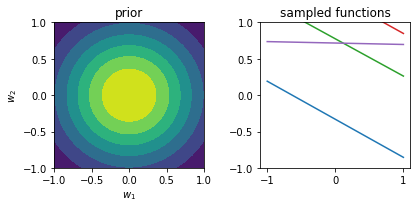

In [5]:
import scipy.stats as stats

fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# Create an X-Y grid for plotting
x = np.linspace(-1, 1, 200)
y = np.linspace(-1, 1, 200)
xv, yv = np.meshgrid(x, y)
xy = np.concatenate(
    [np.expand_dims(xv, axis=-1), 
     np.expand_dims(yv, axis=-1)], axis=-1
)


# Add the extra input dimension for the bias
x_ = np.stack(
    (np.ones(len(x)), x), 1
)


# Plot the prior
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_xlabel('$w_1$')
axs[0].set_ylabel('$w_2$')
axs[0].contourf(xv, yv, prior.pdf(xy), cmap=plt.cm.viridis)
axs[0].set_title('prior')


# Plot functions with sampled parameters, 
# evaluated between [-1, 1].
num_samples = 6
w_samples = prior.rvs(num_samples)
for w in w_samples:
    y_hat = model(x_, w)
    axs[1].plot(x, y_hat)
    axs[1].set_ylim([-1, 1])
    axs[1].set_title('sampled functions')
    
plt.tight_layout()

#### Likelihood

\begin{align}
p(\mathbf{y}|X,\mathbf{w}) &= \prod_{i=1}^N p(y_i,\mathbf{x}_i,\mathbf{w})\\
 &= \frac{1}{(2\pi\sigma^2)^{N/2}}\exp\left(-\frac{1}{2\sigma^2 }(\mathbf{y}-X\mathbf{w})^2\right)
\end{align}

In [6]:
def log_likelihood(y, x, w):
    ll = (-(N/2.0)*np.log(2*np.pi*SIG_SQ) 
          - (1.0/(2*SIG_SQ))*((y - x.dot(w))**2).sum())
    return ll

#### Posterior

\begin{align}
p(\mathbf{w}|X,\mathbf{y}) &\sim \mathcal{N}(\bar{\mathbf{w}}, C_{xx}^{-1})\\
\bar{\mathbf{w}} &= \frac{1}{\sigma^2}C_{xx}^{-1}X^\top\mathbf{y}\\
C_{xx} &= \frac{1}{\alpha}I + \sigma^{-2}X^\top X
\end{align}

#### Observe one datapoint


In [7]:
def get_posterior(X, y):
    # Analytic form of the posterior
    Cxx = (1/ALPHA*np.eye(2) + 1/SIG_SQ*np.dot(X.T, X))
    Cxx_inv = np.linalg.inv(Cxx)
    mean = (1/SIG_SQ)*Cxx_inv.dot(X.T.dot(y))

    posterior = stats.multivariate_normal(
            mean=mean,
            cov=Cxx_inv
    )
    return posterior


X = X_TRUE[:1]
y = Y_TRUE[:1]

posterior = get_posterior(X, y)
w_samples = posterior.rvs(6)


Let's see the likelihood, and how the posterior and model samples look after incorporating one observation.

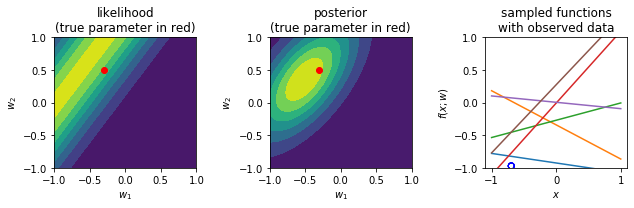

In [8]:
likelihoods = []
for w in xy.reshape(-1, 2):
    l = log_likelihood(y, X, w)
    likelihoods.append(l)
likelihoods = np.exp(np.array(likelihoods).reshape((xy.shape[0], xy.shape[1])))

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].contourf(xv, yv, likelihoods)
axs[0].scatter(W_TRUE[0], W_TRUE[1], color='red')
axs[0].set_title("likelihood\n(true parameter in red)")
axs[0].set_xlabel("$w_1$")
axs[0].set_ylabel("$w_2$")

axs[1].contourf(xv, yv, posterior.pdf(xy))
axs[1].scatter(W_TRUE[0], W_TRUE[1], color='red')
axs[1].set_title('posterior\n(true parameter in red)')
axs[1].set_xlabel("$w_1$")
axs[1].set_ylabel("$w_2$")

for w in w_samples:
    y_hat = model(x_, w)
    axs[2].plot(x, y_hat)
    axs[2].scatter(X[:, 1], y, facecolors='none', edgecolors='b')
    axs[2].set_ylim([-1, 1])
    axs[2].set_title('sampled functions\nwith observed data')
    axs[2].set_xlabel('$x$')
    axs[2].set_ylabel('$f(x;w)$')


plt.tight_layout()

#### Predictive Distribution

We form a distribution over a **prediction** $\tilde{y}$ for a **new observation** $\tilde{\mathbf{x}}$:

\begin{align}
p(\tilde{y}|\tilde{\mathbf{x}},X,\mathbf{y}) &= \int p(\tilde{y}|\tilde{\mathbf{x}}, \mathbf{w})\underbrace{p(\mathbf{w}|X,\mathbf{y})}_{\text{posterior}}d\mathbf{w}\\
&= \mathcal{N}\left(\underbrace{\frac{1}{\sigma^2}\tilde{\mathbf{x}}^\top C_{xx}^{-1}X^\top\mathbf{y}}_{\text{mean}},  \underbrace{\tilde{\mathbf{x}}^\top C_{xx}^{-1}\tilde{\mathbf{x}}}_{\text{variance}} \right)
\end{align}

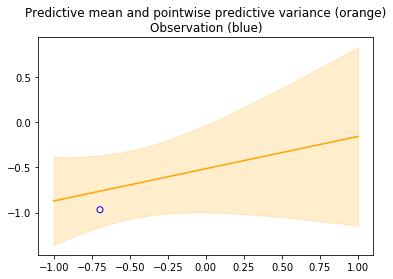

In [9]:
def get_predictive(X_new, X, y):
    Cxx = (1/ALPHA*np.eye(2) + 1/SIG_SQ*np.dot(X.T, X))
    Cxx_inv = np.linalg.inv(Cxx)
    mn = (1/SIG_SQ)*Cxx_inv.dot(X.T.dot(y))

    ms, vs = [], []
    for x_new in X_new:
        mean = x_new.dot(mn)
        var = np.dot(x_new, Cxx_inv.dot(x_new))

        predictive = stats.multivariate_normal(
            mean=mean,
            cov=var
        )

        ms.append(mean)
        vs.append(var)

    ms = np.array(ms)
    vs = np.array(vs)
    return predictive, ms, vs


X_new = np.stack((
    np.ones(100),
    np.linspace(-1, 1, 100)), 1
)
predictive, ms, vs = get_predictive(
    X_new, X, y
)

# Plot
xs = X_new[:, 1]
fig, ax = plt.subplots(1)
plt.plot(xs, ms, color='orange')
plt.fill_between(
    xs, ms - np.sqrt(vs), ms + np.sqrt(vs),
    color='orange',
    alpha=0.2
);

plt.scatter(X[:, 1], y, facecolors='none', edgecolors='b');
plt.title('Predictive mean and pointwise predictive variance (orange)\nObservation (blue)');

#### Observing more data

Now we will see how the likelihood, posterior, model samples, and predictive distribution change as we observe more data.

NOTE: this is based on the **same code from above**

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(15, 12))

for i, n_observed in enumerate([1, 2, 5, 100]):
    X, y = X_TRUE[:n_observed], Y_TRUE[:n_observed]
    
    # -- Likelihood
    likelihoods = []
    for w in xy.reshape(-1, 2):
        l = log_likelihood(y, X, w)
        likelihoods.append(l)
    likelihoods = np.exp(np.array(likelihoods).reshape((xy.shape[0], xy.shape[1])))
    
    # -- Posterior
    posterior = get_posterior(X, y)
    
    # -- Model Samples
    w_samples = posterior.rvs(6)

    # -- Predictive 
    X_new = np.stack((
    np.ones(100),
        np.linspace(-1, 1, 100)), 1
    )
    _, ms, vs = get_predictive(
        X_new, X, y
    )
    
    # -- Plots
    axs[i, 1].contourf(xv, yv, likelihoods)
    axs[i, 1].scatter(W_TRUE[0], W_TRUE[1], color='red')
    if i == 0:
        axs[i, 1].set_title("likelihood\n(true parameter in red)")
    axs[i, 1].set_xlabel("$w_1$")
    axs[i, 1].set_ylabel("$w_2$")

    axs[i, 2].contourf(xv, yv, posterior.pdf(xy))
    axs[i, 2].scatter(W_TRUE[0], W_TRUE[1], color='red')
    if i == 0:
        axs[i, 2].set_title('posterior\n(true parameter in red)')
    axs[i, 2].set_xlabel("$w_1$")
    axs[i, 2].set_ylabel("$w_2$")

    for w in w_samples:
        y_hat = model(X_new, w)
        axs[i, 3].plot(X_new[:, 1], y_hat)
        axs[i, 3].scatter(X[:, 1], y, facecolors='none', edgecolors='b')
        axs[i, 3].set_ylim([-1, 1])
        if i == 0:
            axs[i, 3].set_title('sampled functions\n(observed data in blue)')

    axs[i, 4].plot(xs, ms, color='orange')
    axs[i, 4].fill_between(
        X_new[:, 1], ms - np.sqrt(vs), ms + np.sqrt(vs),
        color='orange',
        alpha=0.2
    );

    axs[i, 4].scatter(X[:, 1], y, facecolors='none', edgecolors='b');
    if i == 0:
        axs[i, 4].set_title('predictive\n(observed data in blue)');
    
    axs[i, 0].text(0, 0.5, '# observed: %d' % n_observed, fontsize=15)
    axs[i, 0].axis('off')

plt.tight_layout()

# BONUS: Gaussian Processes

#### Kernel

First, we will transform our inputs using **basis** functions:
\begin{align}
\phi(\mathbf{x})&\rightarrow \mathbb{R}^K&\\
\end{align}

Now let us consider the mean and covariance of our linear regression model:
\begin{align}
f(\mathbf{x};\mathbf{w})&=\phi(\mathbf{x})^\top\mathbf{w}\\
\underbrace{\mathbb{E}\left[f(\mathbf{x};\mathbf{w})\right]}_{\text{mean}} &= \phi(\mathbf{x})\mathbb{E}[\mathbf{w}] = 0\\
\underbrace{\mathbb{E}\left[f(\mathbf{x};\mathbf{w})f(\mathbf{x'};\mathbf{w})\right]}_{\text{covariance}} &= \phi(\mathbf{x})^\top\mathbb{E}[\mathbf{w}\mathbf{w}^\top]\phi(\mathbf{x'})\\
&= \phi(\mathbf{x})^\top\Sigma\phi(\mathbf{x'})\\
&= \underbrace{k(\mathbf{x}, \mathbf{x'})}_{\text{kernel function}}
\end{align}

where above we took $\Sigma=\alpha I$.

To summarize, we started with a **model** and showed that we can write the covariance in terms of a **kernel function**.

#### Gaussian Process

It turns out that specifying the **mean** and **covariance** as we did above shows that Bayesian Linear Regression is a **Gaussian Process**,

$$f(\mathbf{x})\sim \mathcal{GP}\left(\mathbf{0}, k(\mathbf{x}, \mathbf{x'})\right).$$


We can define other Gaussian Processes by **choosing a different kernel function** $k(\mathbf{x}, \mathbf{x'})$. 

For further details, see Chapter 2 of _Gaussian Processes for Machine Learning_ by Rasmussen and Williams.

#### Scikit Learn

Let's use a Gaussian process from `scikit-learn` to do a slightly more sophisticated regression problem:


In [ ]:
rng = np.random.RandomState(0)

# Generate sample data
X = 15 * rng.rand(100, 1)
y = np.sin(X).ravel()
y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise


plt.scatter(X, y);
plt.ylim([-4, 4]);
plt.title('Observations');

To start, let's use a **Radial Basis Function** kernel,

$$k(x_i, x_j)=\exp\left(-\frac{1}{2}d\left(\frac{x_i}{l}, \frac{x_j}{l}\right)\right)^2$$

A cool feature of Gaussian Processes is that we can **learn/estimate** the **hyperparameters**, in this case the **length-scale $l$** and the **data noise level**.

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels

# dot product kernel: bayesian linear regression
# kernels.DotProduct()
gp_kernel = (kernels.RBF() +               # try kernels.ExpSineSquared(1.0, 5.0)
             kernels.WhiteKernel())        # Models the noise level

gpr = GaussianProcessRegressor(kernel=gp_kernel)

gpr.fit(X, y);

In [ ]:
X_plot = np.linspace(0, 20, 100)[:, None]

y_gpr, y_std = gpr.predict(X_plot, return_std=True)


plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='k', label='data')
plt.plot(X_plot, np.sin(X_plot), color='navy', lw=2, label='True')

plt.plot(X_plot, y_gpr, color='darkorange', lw=2,
         label='GPR (%s)' % gpr.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr - y_std, y_gpr + y_std, color='darkorange',
                 alpha=0.2)
plt.xlabel('data')
plt.ylabel('target')
plt.xlim(0, 20)
plt.ylim(-4, 4)
plt.title('Gaussian Process Regression')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
plt.show()

In [ ]:
gpr.log_marginal_likelihood()